In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
import joblib
from sklearn.model_selection import learning_curve

# hide warnings
import warnings
warnings.filterwarnings('ignore')

In [31]:
df=pd.read_csv('../csv/car_price_analize.csv')

## Conversion to categorical variable

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    204 non-null    int64  
 1   Unnamed: 0      204 non-null    int64  
 2   car_ID          204 non-null    int64  
 3   symboling       204 non-null    int64  
 4   fueltype        204 non-null    object 
 5   aspiration      204 non-null    object 
 6   doornumber      204 non-null    object 
 7   carbody         204 non-null    object 
 8   drivewheel      204 non-null    object 
 9   enginelocation  204 non-null    object 
 10  wheelbase       204 non-null    float64
 11  carlength       204 non-null    float64
 12  carwidth        204 non-null    float64
 13  curbweight      204 non-null    int64  
 14  enginetype      204 non-null    object 
 15  cylindernumber  204 non-null    object 
 16  enginesize      204 non-null    int64  
 17  fuelsystem      204 non-null    obj

In [33]:
# converting symboling to categorical
df['symboling'] = df['symboling'].astype('object')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 204 entries, 0 to 203
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    204 non-null    int64  
 1   Unnamed: 0      204 non-null    int64  
 2   car_ID          204 non-null    int64  
 3   symboling       204 non-null    object 
 4   fueltype        204 non-null    object 
 5   aspiration      204 non-null    object 
 6   doornumber      204 non-null    object 
 7   carbody         204 non-null    object 
 8   drivewheel      204 non-null    object 
 9   enginelocation  204 non-null    object 
 10  wheelbase       204 non-null    float64
 11  carlength       204 non-null    float64
 12  carwidth        204 non-null    float64
 13  curbweight      204 non-null    int64  
 14  enginetype      204 non-null    object 
 15  cylindernumber  204 non-null    object 
 16  enginesize      204 non-null    int64  
 17  fuelsystem      204 non-null    obj

## New features

In [34]:
#Fuel economy
df['fueleconomy'] = (0.55 * df['citympg']) + (0.45 * df['highwaympg'])

## Train test split

In [35]:
# split into X and y
X = df.loc[:, ['symboling', 'fueltype', 'aspiration', 'doornumber',
       'carbody', 'drivewheel', 'enginelocation', 'wheelbase', 'carlength',
       'carwidth', 'curbweight', 'enginetype', 'cylindernumber',
       'enginesize', 'fuelsystem', 'boreratio',
       'horsepower', 'fueleconomy',
       'car_company']]

y = df['price']

In [36]:
# subset all categorical variables
cars_categorical = X.select_dtypes(include=['object'])
cars_categorical.head()

,symboling,fueltype,aspiration,doornumber,carbody,drivewheel,enginelocation,enginetype,cylindernumber,fuelsystem,car_company
0,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alpha-romeo
1,3,gas,std,two,convertible,rwd,front,dohc,four,mpfi,alpha-romeo
2,1,gas,std,two,hatchback,rwd,front,ohcv,six,mpfi,alpha-romeo
3,2,gas,std,four,sedan,fwd,front,ohc,four,mpfi,audi
4,2,gas,std,four,sedan,4wd,front,ohc,five,mpfi,audi


In [37]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    train_size=0.7,
                                                    test_size = 0.3, random_state=100)

## Pipelines creation

In [38]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder

In [39]:
#Pipeline de préprocessing pour les variables numériques
numeric_features = ['wheelbase', 'carlength', 'carwidth', 'curbweight',
                    'enginesize', 'boreratio', 'horsepower','fueleconomy']

numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='mean')),
        ('stdscaler', MinMaxScaler()),  # moyenne nulle et écart type = 1 -> Reg, SVM, PCA
        ])

# Pipeline de pre-processing pour les variables catégorielles
categorial_features = [ "symboling", "fueltype", "aspiration", "doornumber", "carbody", 'drivewheel',
                       "enginelocation", "enginetype",	"cylindernumber", "fuelsystem", "car_company"]

categorical_transformer = OneHotEncoder(sparse=True, handle_unknown='ignore')

# a l'aide de la classe ColumnTransformer, 
# on déclare à quelles variables on applique quel transformer
from sklearn.compose import ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorial_features)
    ], remainder="passthrough"
)

## Linear regression model

In [40]:
modele_reg_lin = linear_model.LinearRegression()


pipe_reg = Pipeline([
     ('prep', preprocessor),
     ('lin', modele_reg_lin)
])

### Training

In [41]:
trained_pipe_reg = pipe_reg.fit(X_train,y_train)
trained_pipe_reg.score(X_test, y_test)

0.9029821403470868

### Learning curves

[ 11  22  33  45  56  67  79  90 101 113]


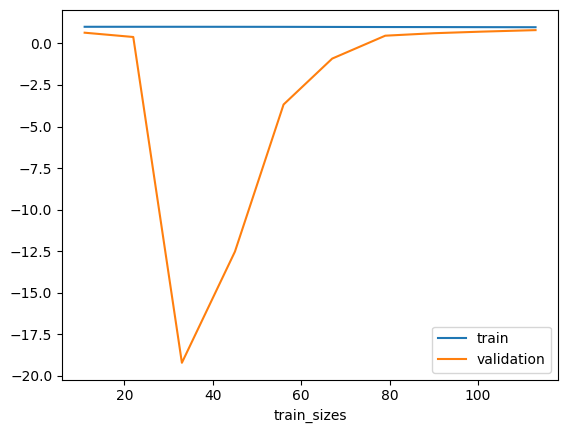

In [42]:
N, train_score, val_score = learning_curve(trained_pipe_reg, X_train, y_train,
                                         train_sizes= np.linspace(0.1, 1.0, 10), cv=5, scoring='r2')

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

plt.show()


### Model exportation

In [43]:
joblib.dump(trained_pipe_reg, "../models/trained_pipe_reg.joblib", compress=True)

['../models/trained_pipe_reg.joblib']

## Ridge model

### Best hyperparameters

In [44]:
# Créer un pipeline qui combine le preprocessor et le modèle à entraîner
pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', Ridge())])

# Définir une grille de paramètres pour la recherche des hyperparamètres
param_grid = {
    'model__alpha': [0.1, 1, 10, 100]
}

# Effectuer une recherche sur la grille des hyperparamètres
grid_search = GridSearchCV(pipe_ridge, param_grid=param_grid, cv=5, scoring= 'r2')
grid_search.fit(X_train, y_train)

# Obtenir les meilleurs hyperparamètres et le score R2 associé
best_params_ridge = grid_search.best_params_['model__alpha']
best_score_ridge = grid_search.best_score_

print("Best params:", best_params_ridge)
print("Best R2 score:", best_score_ridge)

Best params: 1
Best R2 score: 0.8434922069953558


### Model optimization

In [45]:
#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
ridge = linear_model.Ridge(alpha=best_params_ridge)

pipe_ridge_best= Pipeline([
     ('prep', preprocessor),
     ('model', ridge)
])

### Training

In [46]:
trained_pipe_ridge = pipe_ridge_best.fit(X_train,y_train)
trained_pipe_ridge.score(X_test, y_test)

0.8908909016577464

### Model exportation

In [47]:
joblib.dump(trained_pipe_ridge, "../models/trained_pipe_ridge.joblib", compress=True)

['../models/trained_pipe_ridge.joblib']

### Learning curves

[ 11  22  33  45  56  67  79  90 101 113]


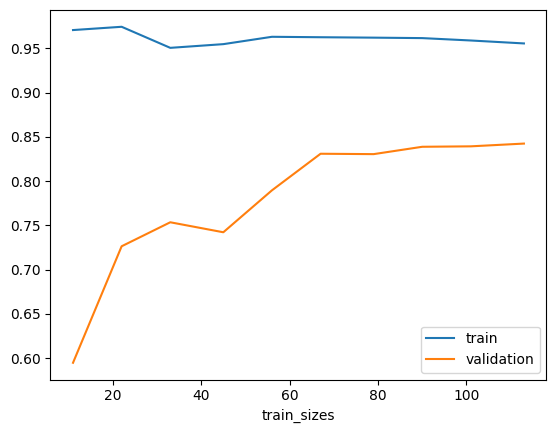

In [48]:
N, train_score, val_score = learning_curve(trained_pipe_ridge, X_train, y_train,
                                         train_sizes= np.linspace(0.1, 1.0, 10), cv=5, scoring='r2')

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

plt.show()

## Lasso model

#### Best hyperparameters

In [49]:
# Créer un pipeline qui combine le preprocessor et le modèle à entraîner
pipe_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', Lasso())])

# Définir une grille de paramètres pour la recherche des hyperparamètres
param_grid = {
    'model__alpha': [0.1, 1, 10, 100]
}

# Effectuer une recherche sur la grille des hyperparamètres
grid_search = GridSearchCV(pipe_ridge, param_grid=param_grid, cv=5, scoring= 'r2')
grid_search.fit(X_train, y_train)

# Obtenir les meilleurs hyperparamètres et le score R2 associé
best_params_lasso = grid_search.best_params_['model__alpha']
best_score_lasso = grid_search.best_score_

print("Best params:", best_params_lasso)
print("Best R2 score:", best_score_lasso)

Best params: 1
Best R2 score: 0.8434922069953558


### Model optimization

In [50]:
#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
lasso = linear_model.Lasso(alpha=best_params_lasso)

pipe_lasso_best= Pipeline([
     ('prep', preprocessor),
     ('model', lasso)
])

### Training

In [51]:
trained_pipe_lasso = pipe_lasso_best.fit(X_train,y_train)
trained_pipe_lasso.score(X_test, y_test)

0.9090031455140292

### Model exportation

In [52]:
joblib.dump(trained_pipe_lasso, "../models/trained_pipe_lasso.joblib", compress=True)

['../trained_pipe_lasso.joblib']

### Learning curves

[ 11  22  33  45  56  67  79  90 101 113]


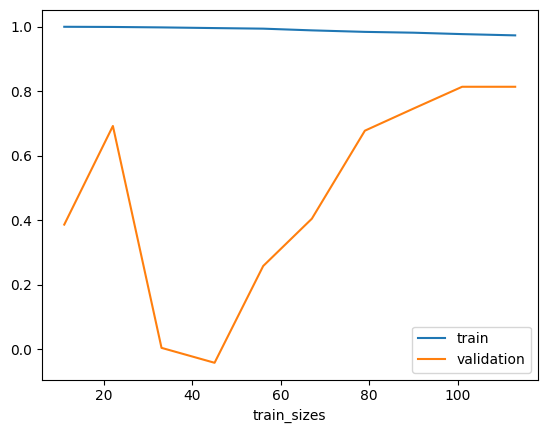

In [53]:
N, train_score, val_score = learning_curve(trained_pipe_lasso, X_train, y_train,
                                         train_sizes= np.linspace(0.1, 1.0, 10), cv=5, scoring='r2')

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

plt.show()

In [54]:
# import matplotlib.pyplot as plt

# # Prédiction des prix pour les données de test
# y_pred = trained_pipe_reg.predict(X_test)

# # Tracé du graphique
# plt.scatter(y_pred, y_test, color='black')

# plt.title("Prix prédit en fonction du prix réel")
# plt.xlabel("Prix prédit")
# plt.ylabel("Prix réel")
# plt.show()

## Random forest model

#### Best hyperparameters

In [55]:
random_forest_params = {
    'random_forest__n_estimators': [50, 100, 200],
    'random_forest__max_depth': [None, 10, 20, 30],
    'random_forest__min_samples_split': [2, 5, 10],
    'random_forest__min_samples_leaf': [1, 2, 4],
    'random_forest__max_features': ['auto', 'sqrt', 'log2'],
}

In [56]:
random_forest_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('random_forest', RandomForestRegressor(random_state=42))
])

In [57]:
random_forest_grid = GridSearchCV(random_forest_pipeline, param_grid=random_forest_params, cv=5, 
                                  scoring='r2')

In [58]:
random_forest_grid.fit(X_train, y_train)

### Model optimization

In [ ]:
# Obtenir les meilleurs hyperparamètres et le score R2 associé
best_params_forest = random_forest_grid.best_params_

best_score_forest = random_forest_grid.best_score_

print("Best parameters for Random Forest:", random_forest_grid.best_params_)
print("Best score for Random Forest:", random_forest_grid.best_score_)

Best parameters for Random Forest: {'random_forest__max_depth': None, 'random_forest__max_features': 'log2', 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 2, 'random_forest__n_estimators': 50}
Best score for Random Forest: 0.8823419625601542


In [ ]:
best_max_depth = random_forest_grid.best_params_['random_forest__max_depth']
best_n_estimators = random_forest_grid.best_params_['random_forest__n_estimators']
best_max_features = random_forest_grid.best_params_['random_forest__max_features']
best_min_samples_leaf = random_forest_grid.best_params_['random_forest__min_samples_leaf']
best_min_samples_split = random_forest_grid.best_params_['random_forest__min_samples_split']

In [ ]:
#On obtient un pipeline de preprocessing qu'on peut utiliser dans un pipeline d'entainement
forest = RandomForestRegressor(n_estimators=best_n_estimators, max_depth = best_max_depth, min_samples_split=best_min_samples_split,
                               min_samples_leaf= best_min_samples_leaf, max_features=best_max_features)

pipe_forest_best= Pipeline([
     ('prep', preprocessor),
     ('model', forest)
])

In [ ]:
trained_pipe_forest = pipe_forest_best.fit(X_train,y_train)
trained_pipe_forest.score(X_test, y_test)

0.9003671863818087

### Exportation du modèle

In [ ]:
joblib.dump(trained_pipe_forest, "../models/trained_pipe_forest.joblib", compress=True)

['trained_pipe_forest.joblib']

### Courbes d'apprentissage

[ 11  22  34  45  57  68  79  91 102 114]


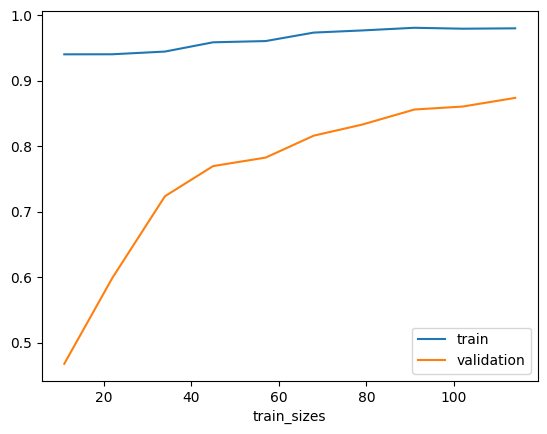

In [ ]:
N, train_score, val_score = learning_curve(trained_pipe_forest, X_train, y_train,
                                         train_sizes= np.linspace(0.1, 1.0, 10), cv=5, scoring='r2')

print(N)
plt.plot(N, train_score.mean(axis=1), label='train')
plt.plot(N, val_score.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()

plt.show()